---

### **Can your model match real clinicians in rural Kenyan healthcare?**

#### **Challenge Overview**

This challenge simulates the critical, real-world medical decisions made by nurses in Kenyan rural health settings. Participants are provided with **400 authentic clinical vignettes**, each representing a scenario faced by healthcare workers with limited resources. The task is to **predict the clinician's response** to each vignette, effectively replicating the reasoning of trained professionals.

---

### **Dataset Details**

* **400 training** and **100 test samples** of clinical prompts.
* Prompts cover a wide range of domains: **maternal health, child care, critical care, etc.**
* Each prompt contains:

  * Patient presentation
  * Nurse’s experience
  * Facility type
* Responses are real, written by expert clinicians.
* Dataset is small due to the high cost of collecting high-quality, expert-validated clinical data.

---

### **Goal**

Build an AI model that:

* Accurately **predicts clinician responses**.
* Matches the **nuance and reasoning** of real professionals.
* Can perform **well in low-resource settings**.

---

### **Evaluation Metric**

* **ROUGE Score** (measures text overlap with ground truth)
* Responses are normalized (lowercase, punctuation stripped, paragraph replaced with space).

---

### **Submission Format**

A CSV file with two columns:

```
Master_Index     Clinician
ID_XXXXXX        summary a 30 yr old...
```

---

### **Model & Deployment Constraints**

Your solution **must**:

* Be **quantized** for low memory usage.
* Run inference in **< 100ms** per vignette.
* Use **< 2 GB RAM** during inference.
* Use **≤ 1 billion parameters**.
* Train within **24 hours on an NVIDIA T4 GPU**.
* Inference should work on an **NVIDIA Jetson Nano** or similar.

---

### **Prizes**

* 🥇 1st: **\$5,000**
* 🥈 2nd: **\$3,000**
* 🥉 3rd: **\$2,000**
* **5,000 Zindi points** also available.
* Winners will be acknowledged in an upcoming publication.

---

### **Judging Criteria (For Top 10 Finalists)**

You must submit a **video** explaining your solution. Judging is based on:

1. **Clarity of explanation** – 25%
2. **Insights/feature engineering** – 15%
3. **Real-world applicability** – 25%
4. **Novelty and real-world constraints** – 25%
5. **Clean, readable code** – 10%

---

### **Rules & Requirements**

* Use **open-source** tools and libraries only.
* Max **10 submissions/day**, **300 total**.
* Max **4 people per team**.
* Data **cannot be used outside** this competition.
* If ranked in top 10:

  * Submit code within **48 hours** of request.
  * Code must reproduce leaderboard score.
  * Winners must transfer IP rights of the solution to Zindi.

---

### **Code & Reproducibility**

* Code must be:

  * Deterministic (set seeds).
  * Runnable with no paid tools or credit card trials.
  * Free of custom packages.
* If code fails to run or reproduce scores, you will be disqualified from top positions.

---

### **Disqualification Policy**

* **First offence**: 6-month ban from prizes + 2000 point deduction.
* **Second offence**: Permanent ban.

---

### **Leaderboard Mechanics**

* Public leaderboard: \~20–30% of test set.
* Private leaderboard: \~70–80%, revealed at end.
* Final scores and ranks are based on **private leaderboard**.
* Ties are broken by **earliest submission time**.

---

This challenge is a **high-impact opportunity** to build real-world, deployable AI for global healthcare—especially in **resource-constrained environments**.


In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install required packages
!pip install huggingface_hub[hf_xet] -q
!pip install rouge-score -q
!pip install nlpaug -q



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 54.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 12.7 MB/s eta 0:00:00
Checking for required NLTK data...
Error downloading NLTK data: name 'nltk' is not defined


In [ ]:
# Place this cell after your challenge description markdown and before data loading

import os
import random
import numpy as np
import pandas as pd
import torch
import re
import gc
import time
import psutil
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    EarlyStoppingCallback,
    DataCollatorForSeq2Seq,
    GenerationConfig
)
from datasets import Dataset
from rouge_score import rouge_scorer
from torch.quantization import quantize_dynamic

import nlpaug.augmenter.word as naw

In [ ]:
# CONSTANTS
MODEL_NAME = 'all-MiniLM-L6-v2'
SEQ2SEQ_MODEL_NAME = 't5-small'
SUBMISSION_CSV = 'submission.csv'
RANDOM_SEED = 42
TRAIN_BATCH_SIZE = 4
EVAL_BATCH_SIZE = 4
NUM_EPOCHS = 60
MAX_LENGTH = 128
GEN_MAX_LENGTH = 128
NUM_BEAMS = 4
EARLY_STOPPING_PATIENCE = 10

# Set random seed for reproducibility
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

In [ ]:

# Paths and constants
DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/Kenya-Challenge-V2/'

TRAIN_CSV = os.path.join(DATA_DIR, 'data/train.csv')
TEST_CSV  = os.path.join(DATA_DIR, 'data/test.csv')
# SAMPLE_SUB = os.path.join(DATA_DIR, 'SampleSubmission.csv')
OUTPUT_DIR = os.path.join(DATA_DIR, 'output')
os.makedirs(OUTPUT_DIR, exist_ok=True)

TRAINING_OUTPUT_DIR = os.path.join(OUTPUT_DIR, 'training_results')
os.makedirs(TRAINING_OUTPUT_DIR, exist_ok=True)
SUBMISSION_FILE_PATH = os.path.join(OUTPUT_DIR, SUBMISSION_CSV)

In [ ]:
# Download necessary NLTK data for nlpaug (SynonymAug)
try:
    print("Checking for required NLTK data...")
    # Downloads are quiet by default unless download_dir is specified
    # Using quiet=True explicitly for clarity
    nltk.download('punkt_tab', quiet=True)
    nltk.download('punkt', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('averaged_perceptron_tagger_eng', quiet=True)
    nltk.download('averaged_perceptron_tagger', quiet=True)
    print("Required NLTK data is available or downloaded.")
except Exception as e:
    print(f"Error downloading NLTK data: {e}")
    print("Warning: NLTK data download failed. Data augmentation may not work.")
    

## Data loading


In [ ]:
try:
    df_train = pd.read_csv(TRAIN_CSV)
    df_test = pd.read_csv(TEST_CSV)

    print(f"Shape of df_train: {df_train.shape}")
    print(f"Shape of df_test: {df_test.shape}")

    print("\nColumns of df_train:")
    print(df_train.columns)
    print("\nColumns of df_test:")
    print(df_test.columns)

    print("\nFirst 5 rows of df_train:")
    display(df_train.head())
    print("\nFirst 5 rows of df_test:")
    display(df_test.head())

except FileNotFoundError:
    print("Error: One or both of the CSV files were not found.")
except pd.errors.ParserError:
    print("Error: There was a problem parsing the CSV file(s). Check the file format.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Shape of df_train: (400, 12)
Shape of df_test: (100, 7)

Columns of df_train:
Index(['Master_Index', 'County', 'Health level', 'Years of Experience',
       'Prompt', 'Nursing Competency', 'Clinical Panel', 'Clinician', 'GPT4.0',
       'LLAMA', 'GEMINI', 'DDX SNOMED'],
      dtype='object')

Columns of df_test:
Index(['Master_Index', 'County', 'Health level', 'Years of Experience',
       'Prompt', 'Nursing Competency', 'Clinical Panel'],
      dtype='object')

First 5 rows of df_train:


,Master_Index,County,Health level,Years of Experience,Prompt,Nursing Competency,Clinical Panel,Clinician,GPT4.0,LLAMA,GEMINI,DDX SNOMED
0,ID_VBWWP,uasin gishu,sub county hospitals and nursing homes,18.0,i am a nurse with 18 years of experience in ge...,pediatric emergency burns,surgery,summary a 4 year old with 5 superficial burns ...,given your vast experience as a nurse in uasin...,1 immediate treatment protocol for second degr...,here s a response addressing the questions reg...,288514009 burn involving 5 percent of body sur...
1,ID_XMBBY,uasin gishu,national referral hospitals,17.0,i am a nurse with 17 years of experience in ge...,child health,paediatrics,summary 6 year old present with vomiting and a...,clinical summary • a 6 year old girl with know...,based on the symptoms and signs you ve describ...,based on the presentation the 6 year old girl ...,420270002 ketoacidosis due to type 1 diabetes ...
2,ID_JZNZW,kiambu,sub county hospitals and nursing homes,12.0,i am a nurse with 12 years of experience in ge...,general emergency,internal medicine,summary a 47 year old man presents with severe...,in this case you re dealing with a 47 year old...,firstly i must commend you on your thorough hi...,this 47 year old male presenting with severe r...,13200003 peptic ulcer disorder 25458004 acute ...
3,ID_QOQTK,uasin gishu,national referral hospitals,12.0,i am a nurse with 12 years of experience in pr...,critical care,internal medicine,summary 72 year old female with inability to w...,given er s clinical presentation and vitals th...,to me with this query based on the information...,this 92 year old female patient er presents wi...,14760008 constipation finding 419284004 altere...
4,ID_ZFJBM,uasin gishu,national referral hospitals,16.0,i am a nurse with 16 years of experience in ge...,adult health,internal medicine,a 22 year old female presents with headache di...,the 22 year old female patient is presenting w...,thank you for presenting this case based on th...,this 22 year old female patient presents with ...,95874006 carbon monoxide poisoning from fire d...



First 5 rows of df_test:


,Master_Index,County,Health level,Years of Experience,Prompt,Nursing Competency,Clinical Panel
0,ID_CUAOY,uasin gishu,sub county hospitals and nursing homes,2.0,i am a nurse with 2 years of experience in gen...,adult health,surgery ent
1,ID_OGSAY,kiambu,sub county hospitals and nursing homes,22.0,i am a nurse with 22 years of experience in ge...,child health,surgery
2,ID_TYHSA,uasin gishu,national referral hospitals,NaN,i am a nurse working in a national referral ho...,general emergency,internal medicine
3,ID_CZXLD,kakamega,dispensaries and private clinics,NaN,i am a nurse working in a dispensaries and pri...,child health,paediatrics
4,ID_ZJQUQ,kakamega,health centres,NaN,i am a nurse working in a health centres in ka...,child health,paediatrics


## Data exploration

Explore and analyze the loaded datasets.


Data Types in df_train:
Master_Index            object
County                  object
Health level            object
Years of Experience    float64
Prompt                  object
Nursing Competency      object
Clinical Panel          object
Clinician               object
GPT4.0                  object
LLAMA                   object
GEMINI                  object
DDX SNOMED              object
dtype: object

Data Types in df_test:
Master_Index            object
County                  object
Health level            object
Years of Experience    float64
Prompt                  object
Nursing Competency      object
Clinical Panel          object
dtype: object

Unique values in County (df_train):
['uasin gishu' 'kiambu' 'kakamega' 'elgeiyo marakwet' 'bungoma']

Unique values in County (df_test):
['uasin gishu' 'kiambu' 'kakamega' 'elgeiyo marakwet']


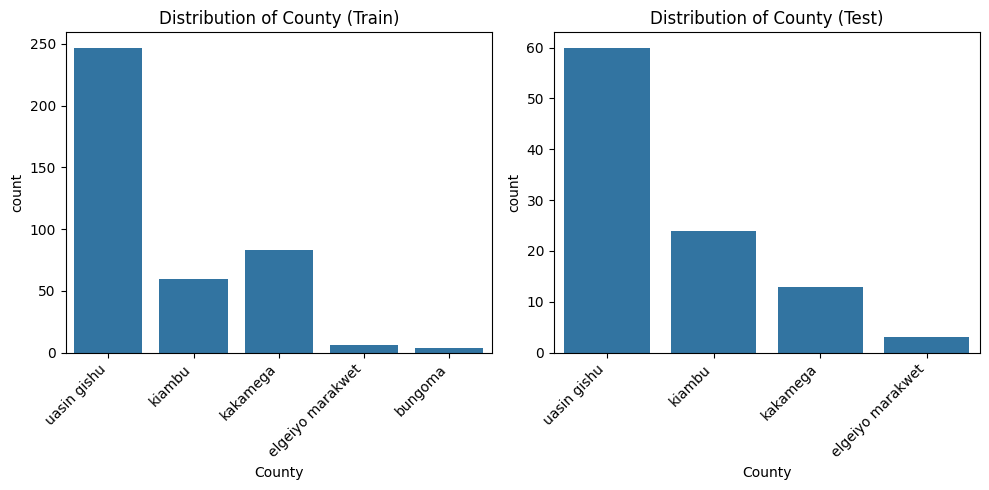


Unique values in Health level (df_train):
['sub county hospitals and nursing homes' 'national referral hospitals'
 'health centres' 'dispensaries and private clinics' 'county hospitals'
 'community health centers' 'health centers']

Unique values in Health level (df_test):
['sub county hospitals and nursing homes' 'national referral hospitals'
 'dispensaries and private clinics' 'health centres' 'county hospitals'
 'community health centers']


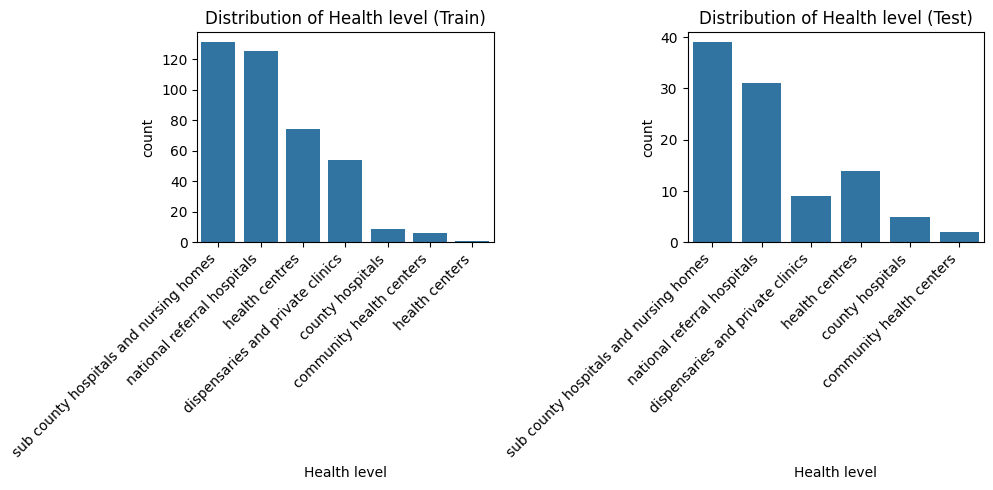


Unique values in Years of Experience (df_train):
[18. 17. 12. 16. 20. nan  8. 14. 15.  1. 23.  9. 31. 24. 10. 22. 30. 27.
 19. 13.  2. 29. 21.  3. 26. 38.  7.  5. 11.]

Unique values in Years of Experience (df_test):
[ 2. 22. nan 10. 30. 15. 12. 17. 16.  1. 20. 27. 18. 31.  9. 14. 24. 26.
 23. 29.  6.]


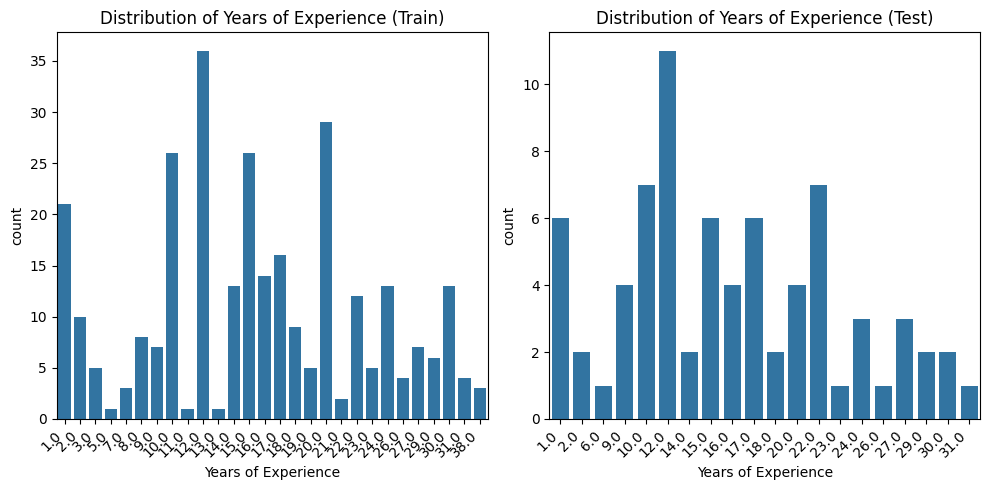


Descriptive statistics for Prompt Length (df_train):
count    400.000000
mean      99.355000
std       27.916883
min       41.000000
25%       81.750000
50%       96.000000
75%      111.250000
max      252.000000
Name: Prompt_Length, dtype: float64


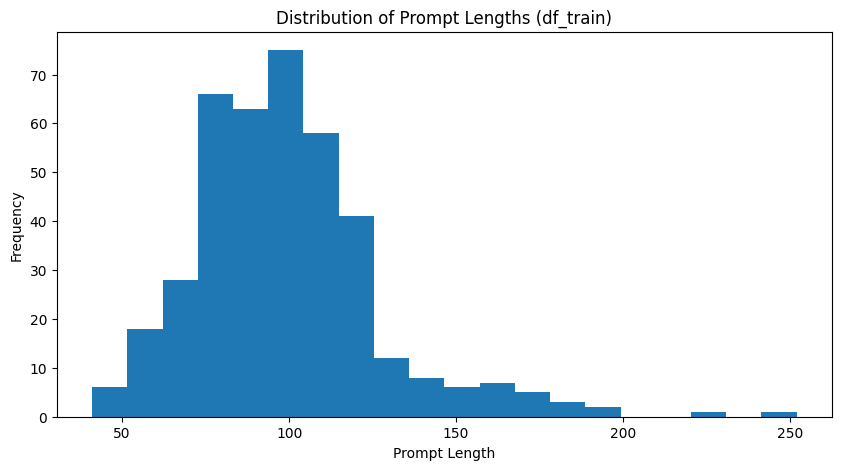


Descriptive statistics for Clinician Length (df_train):
count    400.000000
mean     109.010000
std       44.714521
min       29.000000
25%       76.000000
50%      103.000000
75%      132.000000
max      320.000000
Name: Clinician_Length, dtype: float64


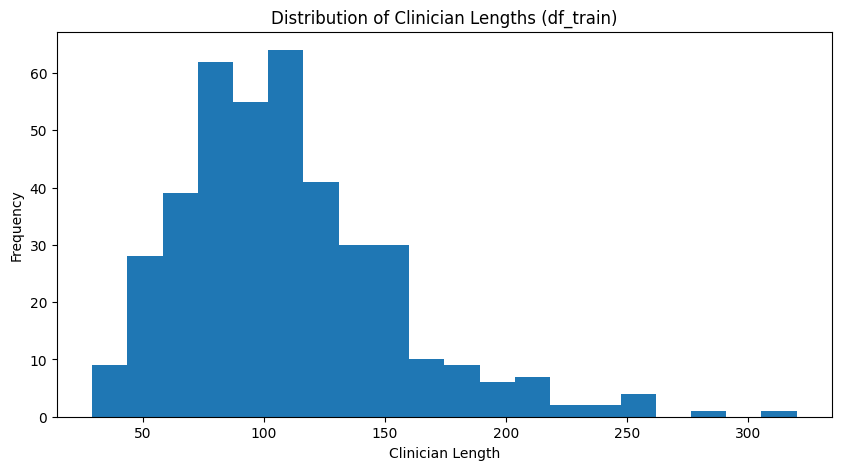


Missing Values in df_train:
Master_Index             0
County                   0
Health level             0
Years of Experience    100
Prompt                   0
Nursing Competency       0
Clinical Panel           0
Clinician                0
GPT4.0                   0
LLAMA                    0
GEMINI                   0
DDX SNOMED               1
Prompt_Length            0
Clinician_Length         0
dtype: int64

Missing Values in df_test:
Master_Index            0
County                  0
Health level            0
Years of Experience    25
Prompt                  0
Nursing Competency      0
Clinical Panel          0
dtype: int64

Average Clinician Response Length:
109.01


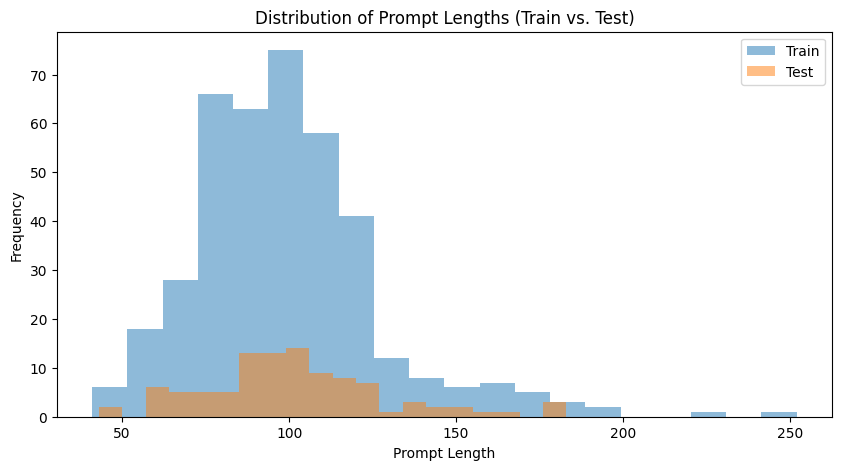

In [ ]:
# 1. Examine data types
print("Data Types in df_train:")
print(df_train.dtypes)
print("\nData Types in df_test:")
print(df_test.dtypes)

# 2. Investigate unique values and distributions for categorical features
categorical_cols = ['County', 'Health level', 'Years of Experience']
for col in categorical_cols:
    print(f"\nUnique values in {col} (df_train):")
    print(df_train[col].unique())
    print(f"\nUnique values in {col} (df_test):")
    print(df_test[col].unique())

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.countplot(x=col, data=df_train)
    plt.title(f'Distribution of {col} (Train)')
    plt.xticks(rotation=45, ha='right')
    plt.subplot(1, 2, 2)
    sns.countplot(x=col, data=df_test)
    plt.title(f'Distribution of {col} (Test)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# 3. Analyze text data length
def text_length(text):
    if isinstance(text, str):
        return len(text.split())
    return 0

df_train['Prompt_Length'] = df_train['Prompt'].apply(text_length)
df_train['Clinician_Length'] = df_train['Clinician'].apply(text_length)

print("\nDescriptive statistics for Prompt Length (df_train):")
print(df_train['Prompt_Length'].describe())
plt.figure(figsize=(10, 5))
plt.hist(df_train['Prompt_Length'], bins=20)
plt.xlabel("Prompt Length")
plt.ylabel("Frequency")
plt.title("Distribution of Prompt Lengths (df_train)")
plt.show()

print("\nDescriptive statistics for Clinician Length (df_train):")
print(df_train['Clinician_Length'].describe())
plt.figure(figsize=(10, 5))
plt.hist(df_train['Clinician_Length'], bins=20)
plt.xlabel("Clinician Length")
plt.ylabel("Frequency")
plt.title("Distribution of Clinician Lengths (df_train)")
plt.show()

# 4. Check for missing values
print("\nMissing Values in df_train:")
print(df_train.isnull().sum())
print("\nMissing Values in df_test:")
print(df_test.isnull().sum())

# 5. Analyze 'Clinician' column
print("\nAverage Clinician Response Length:")
print(df_train['Clinician_Length'].mean())


# 6. Compare Prompt Length distributions (train vs. test)
df_test['Prompt_Length'] = df_test['Prompt'].apply(text_length)

plt.figure(figsize=(10, 5))
plt.hist(df_train['Prompt_Length'], bins=20, alpha=0.5, label='Train')
plt.hist(df_test['Prompt_Length'], bins=20, alpha=0.5, label='Test')
plt.xlabel("Prompt Length")
plt.ylabel("Frequency")
plt.title("Distribution of Prompt Lengths (Train vs. Test)")
plt.legend(loc='upper right')
plt.show()


Distribution of Prompt and Clinician Lengths:
       Prompt_Length  Clinician_Length
count     400.000000        400.000000
mean       99.355000        109.010000
std        27.916883         44.714521
min        41.000000         29.000000
25%        81.750000         76.000000
50%        96.000000        103.000000
75%       111.250000        132.000000
max       252.000000        320.000000


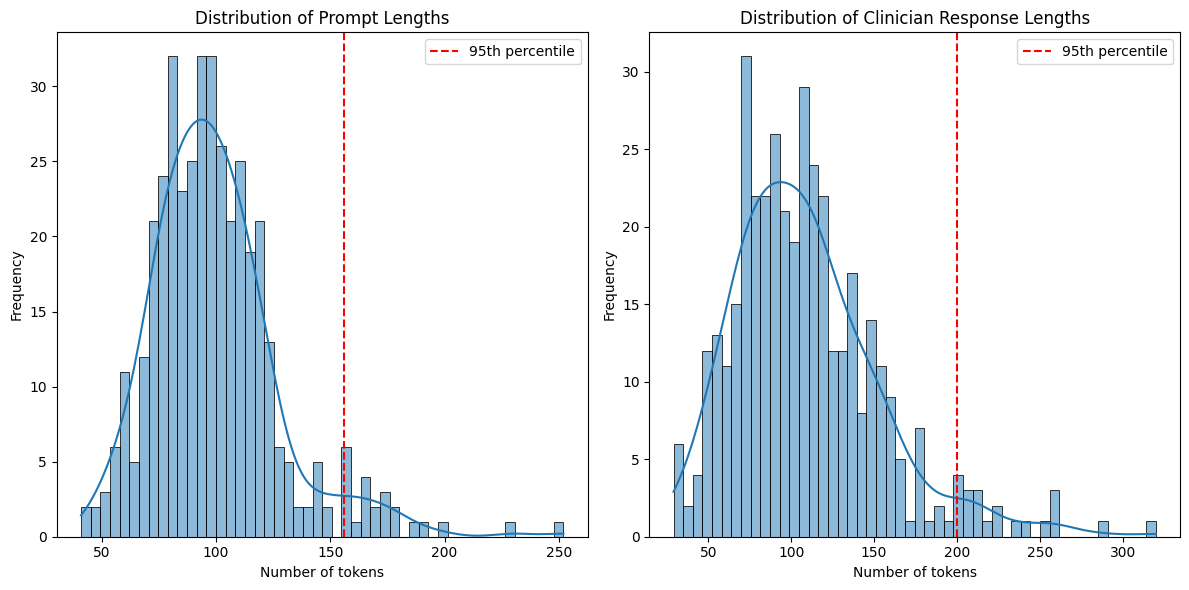


Prompt Length Percentiles:
0.50     96.00
0.75    111.25
0.90    129.00
0.95    156.05
0.99    185.04
Name: Prompt_Length, dtype: float64

Clinician Length Percentiles:
0.50    103.00
0.75    132.00
0.90    161.00
0.95    200.05
0.99    259.01
Name: Clinician_Length, dtype: float64

Suggested updated MAX_LENGTH for training (based on 95th percentile Clinician Length + buffer): 279
Suggested updated GEN_MAX_LENGTH for inference: 279


In [ ]:
# Display descriptive statistics
print("\nDistribution of Prompt and Clinician Lengths:")
print(df_train[['Prompt_Length', 'Clinician_Length']].describe())

# Plot histograms with KDE
plt.figure(figsize=(12, 6))

# Plot Prompt Lengths
plt.subplot(1, 2, 1)
sns.histplot(df_train['Prompt_Length'], bins=50, kde=True)
plt.axvline(df_train['Prompt_Length'].quantile(0.95), color='red', linestyle='--', label='95th percentile')
plt.title("Distribution of Prompt Lengths")
plt.xlabel("Number of tokens")
plt.ylabel("Frequency")
plt.legend()

# Plot Clinician Response Lengths
plt.subplot(1, 2, 2)
sns.histplot(df_train['Clinician_Length'], bins=50, kde=True)
plt.axvline(df_train['Clinician_Length'].quantile(0.95), color='red', linestyle='--', label='95th percentile')
plt.title("Distribution of Clinician Response Lengths")
plt.xlabel("Number of tokens")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()

# Calculate percentiles to help inform max lengths
prompt_percentiles = df_train['Prompt_Length'].quantile([0.5, 0.75, 0.9, 0.95, 0.99])
clinician_percentiles = df_train['Clinician_Length'].quantile([0.5, 0.75, 0.9, 0.95, 0.99])

# Display percentile values
print("\nPrompt Length Percentiles:")
print(prompt_percentiles)

print("\nClinician Length Percentiles:")
print(clinician_percentiles)

# Suggest updated max lengths based on 95th percentile
new_max_length_prompts = int(prompt_percentiles.loc[0.99]) + 10
new_max_length_labels = int(clinician_percentiles.loc[0.95]) + 10

# Align MAX_LENGTH and GEN_MAX_LENGTH with the Clinician response length
updated_MAX_LENGTH = int(clinician_percentiles.loc[0.99]) + 20
updated_GEN_MAX_LENGTH = updated_MAX_LENGTH

print(f"\nSuggested updated MAX_LENGTH for training (based on 95th percentile Clinician Length + buffer): {updated_MAX_LENGTH}")
print(f"Suggested updated GEN_MAX_LENGTH for inference: {updated_GEN_MAX_LENGTH}")

MAX_LENGTH = updated_MAX_LENGTH
GEN_MAX_LENGTH = updated_GEN_MAX_LENGTH


## Data cleaning

Impute missing values in 'Years of Experience', handle the missing value in 'DDX SNOMED' in df_train, and ensure consistency in categorical features across both dataframes.


**Reasoning**:



In [ ]:
# Impute missing 'Years of Experience'
df_train['Years of Experience'] = df_train['Years of Experience'].fillna(df_train['Years of Experience'].median())
df_test['Years of Experience'] = df_test['Years of Experience'].fillna(df_test['Years of Experience'].median())

# Drop the row with the missing value in 'DDX SNOMED'
df_train.dropna(subset=['DDX SNOMED'], inplace=True)

# Ensure consistency in categorical features
for col in ['County', 'Health level', 'Nursing Competency', 'Clinical Panel']:
    if col in df_train.columns and col in df_test.columns:
        unique_train = set(df_train[col].unique())
        unique_test = set(df_test[col].unique())

        # Find inconsistencies
        diff = unique_train.symmetric_difference(unique_test)
        print(f"Inconsistencies in column '{col}': {diff}")

        # Attempt to fix inconsistencies (example: case correction)
        for value in diff:
            if value.lower() in unique_train and value.lower() in unique_test:
                df_train[col] = df_train[col].replace(value, value.lower())
                df_test[col] = df_test[col].replace(value, value.lower())
            # Additional logic for variations in wording could be added here

# Display the first few rows of the cleaned dataframes to verify the changes
display(df_train.head())
display(df_test.head())

Inconsistencies in column 'County': {'bungoma'}
Inconsistencies in column 'Health level': {'health centers'}
Inconsistencies in column 'Nursing Competency': {'emergency care gbv', 'emergency care burns', 'maternah and child health', 'wound and ostomy care', 'emergency care rape', 'mayernal and child health', 'obstetrics emergency', 'pediatric emergency burns', 'neonatal care', 'emergency care adult', 'critical care'}
Inconsistencies in column 'Clinical Panel': {'psychiatry', 'surgery paediatrics', 'surgery opthalmology', 'paediatric neurology', 'internal medicine cardiology', 'internal medicine psychiatry'}


,Master_Index,County,Health level,Years of Experience,Prompt,Nursing Competency,Clinical Panel,Clinician,GPT4.0,LLAMA,GEMINI,DDX SNOMED,Prompt_Length,Clinician_Length
0,ID_VBWWP,uasin gishu,sub county hospitals and nursing homes,18.0,i am a nurse with 18 years of experience in ge...,pediatric emergency burns,surgery,summary a 4 year old with 5 superficial burns ...,given your vast experience as a nurse in uasin...,1 immediate treatment protocol for second degr...,here s a response addressing the questions reg...,288514009 burn involving 5 percent of body sur...,158,47
1,ID_XMBBY,uasin gishu,national referral hospitals,17.0,i am a nurse with 17 years of experience in ge...,child health,paediatrics,summary 6 year old present with vomiting and a...,clinical summary • a 6 year old girl with know...,based on the symptoms and signs you ve describ...,based on the presentation the 6 year old girl ...,420270002 ketoacidosis due to type 1 diabetes ...,124,146
2,ID_JZNZW,kiambu,sub county hospitals and nursing homes,12.0,i am a nurse with 12 years of experience in ge...,general emergency,internal medicine,summary a 47 year old man presents with severe...,in this case you re dealing with a 47 year old...,firstly i must commend you on your thorough hi...,this 47 year old male presenting with severe r...,13200003 peptic ulcer disorder 25458004 acute ...,128,111
3,ID_QOQTK,uasin gishu,national referral hospitals,12.0,i am a nurse with 12 years of experience in pr...,critical care,internal medicine,summary 72 year old female with inability to w...,given er s clinical presentation and vitals th...,to me with this query based on the information...,this 92 year old female patient er presents wi...,14760008 constipation finding 419284004 altere...,88,168
4,ID_ZFJBM,uasin gishu,national referral hospitals,16.0,i am a nurse with 16 years of experience in ge...,adult health,internal medicine,a 22 year old female presents with headache di...,the 22 year old female patient is presenting w...,thank you for presenting this case based on th...,this 22 year old female patient presents with ...,95874006 carbon monoxide poisoning from fire d...,110,137


,Master_Index,County,Health level,Years of Experience,Prompt,Nursing Competency,Clinical Panel,Prompt_Length
0,ID_CUAOY,uasin gishu,sub county hospitals and nursing homes,2.0,i am a nurse with 2 years of experience in gen...,adult health,surgery ent,102
1,ID_OGSAY,kiambu,sub county hospitals and nursing homes,22.0,i am a nurse with 22 years of experience in ge...,child health,surgery,60
2,ID_TYHSA,uasin gishu,national referral hospitals,15.0,i am a nurse working in a national referral ho...,general emergency,internal medicine,90
3,ID_CZXLD,kakamega,dispensaries and private clinics,15.0,i am a nurse working in a dispensaries and pri...,child health,paediatrics,93
4,ID_ZJQUQ,kakamega,health centres,15.0,i am a nurse working in a health centres in ka...,child health,paediatrics,150


## Text Preprocessing

Preprocess the text data by lowercasing, removing punctuation, replacing paragraph markers, and tokenizing the 'Prompt' and 'Clinician' columns in df_train and the 'Prompt' column in df_test.


In [ ]:

# Lowercasing, punctuation removal, and paragraph replacement
def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\s+', ' ', text)
        return text
    return ""

df_train['Prompt'] = df_train['Prompt'].apply(preprocess_text)
df_train['Clinician'] = df_train['Clinician'].apply(preprocess_text)
df_test['Prompt'] = df_test['Prompt'].apply(preprocess_text)

# Tokenization
def tokenize_text(text):
    if isinstance(text, str):
        return word_tokenize(text)
    return []

df_train['Prompt_tokens'] = df_train['Prompt'].apply(tokenize_text)
df_train['Clinician_tokens'] = df_train['Clinician'].apply(tokenize_text)
df_test['Prompt_tokens'] = df_test['Prompt'].apply(tokenize_text)

# Display first few rows to verify
display(df_train.head())
display(df_test.head())

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,Master_Index,County,Health level,Years of Experience,Prompt,Nursing Competency,Clinical Panel,Clinician,GPT4.0,LLAMA,GEMINI,DDX SNOMED,Prompt_Length,Clinician_Length,Prompt_tokens,Clinician_tokens
0,ID_VBWWP,uasin gishu,sub county hospitals and nursing homes,18.0,i am a nurse with 18 years of experience in ge...,pediatric emergency burns,surgery,summary a 4 year old with 5 superficial burns ...,given your vast experience as a nurse in uasin...,1 immediate treatment protocol for second degr...,here s a response addressing the questions reg...,288514009 burn involving 5 percent of body sur...,158,47,"[i, am, a, nurse, with, 18, years, of, experie...","[summary, a, 4, year, old, with, 5, superficia..."
1,ID_XMBBY,uasin gishu,national referral hospitals,17.0,i am a nurse with 17 years of experience in ge...,child health,paediatrics,summary 6 year old present with vomiting and a...,clinical summary • a 6 year old girl with know...,based on the symptoms and signs you ve describ...,based on the presentation the 6 year old girl ...,420270002 ketoacidosis due to type 1 diabetes ...,124,146,"[i, am, a, nurse, with, 17, years, of, experie...","[summary, 6, year, old, present, with, vomitin..."
2,ID_JZNZW,kiambu,sub county hospitals and nursing homes,12.0,i am a nurse with 12 years of experience in ge...,general emergency,internal medicine,summary a 47 year old man presents with severe...,in this case you re dealing with a 47 year old...,firstly i must commend you on your thorough hi...,this 47 year old male presenting with severe r...,13200003 peptic ulcer disorder 25458004 acute ...,128,111,"[i, am, a, nurse, with, 12, years, of, experie...","[summary, a, 47, year, old, man, presents, wit..."
3,ID_QOQTK,uasin gishu,national referral hospitals,12.0,i am a nurse with 12 years of experience in pr...,critical care,internal medicine,summary 72 year old female with inability to w...,given er s clinical presentation and vitals th...,to me with this query based on the information...,this 92 year old female patient er presents wi...,14760008 constipation finding 419284004 altere...,88,168,"[i, am, a, nurse, with, 12, years, of, experie...","[summary, 72, year, old, female, with, inabili..."
4,ID_ZFJBM,uasin gishu,national referral hospitals,16.0,i am a nurse with 16 years of experience in ge...,adult health,internal medicine,a 22 year old female presents with headache di...,the 22 year old female patient is presenting w...,thank you for presenting this case based on th...,this 22 year old female patient presents with ...,95874006 carbon monoxide poisoning from fire d...,110,137,"[i, am, a, nurse, with, 16, years, of, experie...","[a, 22, year, old, female, presents, with, hea..."


,Master_Index,County,Health level,Years of Experience,Prompt,Nursing Competency,Clinical Panel,Prompt_Length,Prompt_tokens
0,ID_CUAOY,uasin gishu,sub county hospitals and nursing homes,2.0,i am a nurse with 2 years of experience in gen...,adult health,surgery ent,102,"[i, am, a, nurse, with, 2, years, of, experien..."
1,ID_OGSAY,kiambu,sub county hospitals and nursing homes,22.0,i am a nurse with 22 years of experience in ge...,child health,surgery,60,"[i, am, a, nurse, with, 22, years, of, experie..."
2,ID_TYHSA,uasin gishu,national referral hospitals,15.0,i am a nurse working in a national referral ho...,general emergency,internal medicine,90,"[i, am, a, nurse, working, in, a, national, re..."
3,ID_CZXLD,kakamega,dispensaries and private clinics,15.0,i am a nurse working in a dispensaries and pri...,child health,paediatrics,93,"[i, am, a, nurse, working, in, a, dispensaries..."
4,ID_ZJQUQ,kakamega,health centres,15.0,i am a nurse working in a health centres in ka...,child health,paediatrics,150,"[i, am, a, nurse, working, in, a, health, cent..."


## Data splitting

Split the training data into training and validation sets.


In [ ]:
if 'df_train' in locals() and isinstance(df_train, pd.DataFrame): # Check if df_train exists and is a DataFrame

    # Impute missing 'Years of Experience' *before* filtering and splitting
    # This ensures the column used for stratification is clean
    print("Checking and imputing missing values in 'Years of Experience'...")
    if df_train['Years of Experience'].isnull().any():
        median_years = df_train['Years of Experience'].median()
        # Use .copy() on df_train before modifying to avoid potential SettingWithCopyWarning issues
        df_train = df_train.copy()
        df_train['Years of Experience'].fillna(median_years, inplace=True)
        print(f"Imputed missing 'Years of Experience' with median: {median_years}")
    else:
        print("'Years of Experience' column has no missing values.")


    # Identify values in 'Years of Experience' that appear only once for stratification
    print("Checking for single-occurrence values in 'Years of Experience' for stratification...")
    value_counts = df_train['Years of Experience'].value_counts()
    values_to_remove = value_counts[value_counts == 1].index
    print(f"Values appearing only once: {list(values_to_remove)}")


    # Remove rows with those values for stratification
    # Ensure this filtering happens *after* imputation
    df_train_filtered = df_train[~df_train['Years of Experience'].isin(values_to_remove)].copy() # Use .copy() to avoid SettingWithCopyWarning
    print(f"Shape of df_train after filtering single-occurrence values: {df_train_filtered.shape}")

    # Verify no NaNs before splitting
    if df_train_filtered['Years of Experience'].isnull().any():
         print("Error: NaN values still present in 'Years of Experience' after imputation and filtering!")
         print("Rows with NaN in 'Years of Experience' before splitting:")
         print(df_train_filtered[df_train_filtered['Years of Experience'].isnull()])
         print("finish_task")
         print('{"status": "failure", "dataframes": []}')
         raise ValueError("NaN values found in 'Years of Experience' column before stratification.")


    # Split the filtered training data
    print("Performing train_test_split...")
    # Using _ for the embedding variables as they are not used by the T5 model
    try:
        # Ensure the 'y' parameter for stratify does not contain NaNs
        stratify_col = df_train_filtered['Years of Experience']
        if stratify_col.isnull().any():
             print("Internal error: stratify_col still contains NaNs before splitting!") # Should be caught by the check above, but defensive
             print("finish_task")
             print('{"status": "failure", "dataframes": []}')
             raise ValueError("NaNs found in stratification column right before splitting.")

        df_train_split, df_val_split, _, _ = train_test_split(
            df_train_filtered,
            stratify_col, # Stratify by the clean 'Years of Experience' column
            test_size=0.2,
            stratify=stratify_col,
            random_state=RANDOM_SEED
        )
        print("Data splitting successful.")
        # Print the shapes of the resulting DataFrames
        print(f"Shape of df_train_split (within training cell): {df_train_split.shape}")
        print(f"Shape of df_val_split (within training cell): {df_val_split.shape}")

    except ValueError as e:
        print(f"ValueError during train_test_split: {e}")
        print("finish_task")
        print('{"status": "failure", "dataframes": []}')
        raise SystemExit # Exit if splitting fails


else:
    print("Error: df_train not found or is not a DataFrame. Cannot perform data splitting.")
    print("finish_task")
    print('{"status": "failure", "dataframes": []}')
    raise SystemExit

Shape of df_train_split: (316, 17)
Shape of df_val_split: (80, 17)
Shape of X_train: (316,)
Shape of X_val: (80,)


# Data Augmentation

In [ ]:
try:
    aug = naw.SynonymAug(aug_src='wordnet')
    print("NLPaug SynonymAug loaded successfully.")
except Exception as e:
    print(f"Error initializing NLPaug SynonymAug: {e}")
    print("Warning: Data augmentation augmenter could not be initialized.")
    # Again, decide if this should halt execution.
    # print("finish_task")
    # print('{"status": "failure", "dataframes": []}')
    # raise SystemExit


# Function to augment a single prompt
# Correction 8: Adjust the augmentation function to handle potential empty results from augment()
def augment_prompt(prompt, num_augments=1):
    augmented_prompts = []
    if not isinstance(prompt, str) or not prompt.strip():
        return [] # Return empty list if prompt is not a valid string

    try:
        # Ensure the input to aug.augment is a list of strings
        results = aug.augment([prompt], n=num_augments) # n specifies number of augmented versions
        # Check if results is a list and contains strings
        if isinstance(results, list):
             augmented_prompts = [text for text in results if isinstance(text, str) and text.strip()]
             # Optionally, if you only want exactly num_augments, you might need to loop and call augment multiple times if a single call returns fewer
             # For now, we'll take whatever augment returns up to num_augments implicitly by how we loop below.
        # Note: If aug.augment returns a single string when num_augments=1, the current logic would still work correctly.
    except Exception as e:
        print(f"Warning: Error augmenting prompt '{prompt[:50]}...': {e}")
        # Continue without augmentation for this prompt

    return augmented_prompts


# Augment the training DataFrame
# Correction 8: Ensure the base dataframe for augmentation exists before proceeding
if 'df_train_split' in locals() and isinstance(df_train_split, pd.DataFrame):
    print("\nStarting data augmentation...")
    augmented_data = []
    # Use iterrows and .copy() to avoid SettingWithCopyWarning
    for index, row in df_train_split.iterrows():
        original_prompt = row['Prompt']
        original_clinician = row['Clinician']

        # Add original data
        augmented_data.append({'Prompt': original_prompt, 'Clinician': original_clinician})

        # Add augmented data (e.g., create 1 augmented version per original)
        # You can experiment with `num_augments`
        # Correction 8: Ensure we handle cases where augment_prompt returns an empty list
        augmented_prompts = augment_prompt(original_prompt, num_augments=1)
        for aug_prompt in augmented_prompts:
            # Ensure the augmented prompt is not empty or just whitespace
            if aug_prompt.strip():
                 augmented_data.append({'Prompt': aug_prompt, 'Clinician': original_clinician}) # Keep the original clinician response

    # Create a new DataFrame from the augmented data
    # Correction 8: Handle the case where augmented_data is empty (e.g., if augmentation failed for all prompts)
    if augmented_data:
        df_train_augmented = pd.DataFrame(augmented_data)
        print(f"Original train split shape: {df_train_split.shape}")
        print(f"Augmented train split shape: {df_train_augmented.shape}")
        # Now create the Hugging Face Dataset from the augmented DataFrame
        train_dataset = Dataset.from_pandas(df_train_augmented[["Prompt", "Clinician"]])
        print("Augmented Hugging Face train_dataset created.")
    else:
        print("Warning: Data augmentation resulted in an empty dataset. Using original train_dataset for training.")
        # Revert to the original train_dataset if augmentation failed
        train_dataset = Dataset.from_pandas(df_train_split[["Prompt", "Clinician"]]) # Ensure original dataset is used

else:
    print("Error: df_train_split not found or is not a DataFrame. Skipping data augmentation.")
    print("finish_task")
    print('{"status": "failure", "dataframes": []}')
    raise SystemExit

## Model training
Train a quantized text generation model using the prepared data.

In [ ]:
gc.collect()
torch.cuda.empty_cache()


# Prepare the training and validation datasets
# These lines now rely on the splitting code that was just included above
if 'train_dataset' in locals() and 'df_val_split' in locals() and isinstance(df_val_split, pd.DataFrame):
    val_dataset = Dataset.from_pandas(df_val_split[["Prompt", "Clinician"]])
    print("Hugging Face Datasets created successfully (using augmented training data if available).")
else:
    print("Error: Data splitting or augmentation failed. Cannot create datasets.")
    print("finish_task")
    print('{"status": "failure", "dataframes": []}')
    raise SystemExit


# Load a pre-trained tokenizer and model
print(f"Loading tokenizer and model from {SEQ2SEQ_MODEL_NAME}...")
try:
    tokenizer = AutoTokenizer.from_pretrained(SEQ2SEQ_MODEL_NAME)
    model = AutoModelForSeq2SeqLM.from_pretrained(SEQ2SEQ_MODEL_NAME)
    print("Tokenizer and model loaded.")
except Exception as e:
    print(f"Error loading tokenizer or model: {e}")
    print("finish_task")
    print('{"status": "failure", "dataframes": []}')
    raise SystemExit


# Preprocess the data (tokenization)
def preprocess_function(examples):
    inputs = [ex for ex in examples["Prompt"]]
    targets = [ex for ex in examples["Clinician"]]
    # Use padding=True with DataCollatorForSeq2Seq for dynamic padding
    model_inputs = tokenizer(inputs, max_length=MAX_LENGTH, truncation=True, padding=True)
    with tokenizer.as_target_tokenizer():
         labels = tokenizer(targets, max_length=MAX_LENGTH, truncation=True, padding=True)

    # Create labels by masking padding tokens
    model_inputs["labels"] = labels["input_ids"].copy()
    # Replace padding token id in labels with -100
    model_inputs["labels"] = [
        [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in model_inputs["labels"]
    ]

    return model_inputs

print("Tokenizing datasets...")
try:
    tokenized_train = train_dataset.map(preprocess_function, batched=True, remove_columns=["Prompt", "Clinician"])
    tokenized_val = val_dataset.map(preprocess_function, batched=True, remove_columns=["Prompt", "Clinician"])
    print("Tokenization complete.")
except Exception as e:
    print(f"Error during dataset tokenization: {e}")
    print("finish_task")
    print('{"status": "failure", "dataframes": []}')
    raise SystemExit

# Define the ROUGE scorer
scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)

# Define the metric function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # Replace -100 in labels with the pad token id
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    rouge_l = 0
    # Ensure decoded_preds and decoded_labels have the same length
    min_len = min(len(decoded_preds), len(decoded_labels))
    for pred, label in zip(decoded_preds[:min_len], decoded_labels[:min_len]):
        score = scorer.score(label, pred)
        rouge_l += score["rougeL"].fmeasure

    # Handle the case where there are no decoded predictions or references
    if min_len == 0:
        return {"rougeL": 0.0}


    return {"rougeL": rouge_l / min_len}

decoder_start_token_id = tokenizer.pad_token_id
if decoder_start_token_id is None:
    # Fallback if pad_token_id is not defined, though unlikely for T5
    if tokenizer.bos_token_id is not None:
        decoder_start_token_id = tokenizer.bos_token_id
        print(f"Warning: tokenizer.pad_token_id is None. Using tokenizer.bos_token_id ({decoder_start_token_id}) as decoder_start_token_id.")
    else:
        # If neither is available, raise an error as generation won't work
        print("Error: Neither tokenizer.pad_token_id nor tokenizer.bos_token_id is available.")
        print("Cannot set decoder_start_token_id for generation.")
        print("finish_task")
        print('{"status": "failure", "dataframes": []}')
        raise ValueError("Decoder start token ID not found for tokenizer.")


generation_config = GenerationConfig(
    max_length=GEN_MAX_LENGTH,
    num_beams=NUM_BEAMS,
    early_stopping=True,
    repetition_penalty=2.5,
    min_length=50,
    pad_token_id=tokenizer.pad_token_id, # Explicitly set pad token id
    eos_token_id=tokenizer.eos_token_id, # Explicitly set eos token id
    decoder_start_token_id=decoder_start_token_id # **Explicitly set the decoder start token ID**
)

training_args = Seq2SeqTrainingArguments(
    output_dir=TRAINING_OUTPUT_DIR, # Corrected output directory
    learning_rate=5e-5,
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=EVAL_BATCH_SIZE,
    weight_decay=0.01,
    save_total_limit=1,
    num_train_epochs=NUM_EPOCHS,
    predict_with_generate=True,
    fp16=torch.cuda.is_available(), # Use mixed precision if CUDA is available
    load_best_model_at_end=True,
    # We pass generation_config object directly to training_args
    # This should ensure it's used during evaluation's generate calls
    generation_config=generation_config,
    metric_for_best_model="rougeL",
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    logging_dir=os.path.join(TRAINING_OUTPUT_DIR, 'logs'), # Corrected logging directory
    logging_steps=50,
    report_to="none" # Prevent reporting to external services unless configured
)

# Create a data collator for sequence to sequence tasks
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=EARLY_STOPPING_PATIENCE)

# Create the Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback],
)

print("Starting model training...")
# Train the model
try:
    trainer.train()
    print("Model training finished.")
except Exception as e:
    print(f"Error during model training: {e}")
    # This is where the original ValueError happened, leading to SystemExit
    # We add a more specific error message before raising
    print("Training failed, potentially due to generation config issue.")
    print("finish_task")
    print('{"status": "failure", "dataframes": []}')
    raise SystemExit #


# Get the path to the best model checkpoint
best_model_path = trainer.state.best_model_checkpoint
if best_model_path is None:
     # If early stopping didn't trigger or no checkpoint saved, use the last checkpoint
    best_model_path = trainer.state.last_checkpoint
    if best_model_path is None:
         # Fallback to the main output directory if no checkpoints were saved
         # This might happen if num_train_epochs is 0 or very low steps
        best_model_path = TRAINING_OUTPUT_DIR

trained_model = None
if best_model_path and os.path.exists(best_model_path):
    print(f"Loading best trained model from: {best_model_path}")
    # Load the best trained model from the checkpoint
    try:
        trained_model = AutoModelForSeq2SeqLM.from_pretrained(best_model_path)
        print("Best trained model loaded successfully.")
    except Exception as e:
        print(f"Error loading best trained model from {best_model_path}: {e}")
        print("finish_task")
        print('{"status": "failure", "dataframes": []}')
        raise SystemExit # Exit if the trained model cannot be loaded
else:
    print(f"Could not find a saved checkpoint at {best_model_path}. Using the final model from training (may not be the best).")
    # If no checkpoint was saved, use the model object directly from the trainer
    # Ensure 'model' object exists from earlier in the cell
    if 'model' in locals() and model is not None:
        trained_model = model
    else:
        print("Error: Trained model could not be loaded or accessed.")
        print("finish_task")
        print('{"status": "failure", "dataframes": []}')
        raise SystemExit

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Map:   0%|          | 0/316 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3959: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/80 [00:00<?, ? examples/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:


Abort: 

## Model Optimization and Quantization

Model Optimization and Quantization for Jetson Nano


In [ ]:

if trained_model is not None:
    print("\nStarting model optimization and quantization...")

    # ==================== DEVICE SETUP ====================
    device = 'cpu'
    print(f"Using device for quantization and inference tests: {device}")

    # Move the trained model to CPU before quantization
    trained_model.to(device)
    trained_model.eval() # Set model to evaluation mode

    # ==================== MODEL SIZE BEFORE QUANTIZATION ====================
    def get_model_size(model_obj):
        param_size = sum(p.nelement() * p.element_size() for p in model_obj.parameters())
        buffer_size = sum(b.nelement() * b.element_size() for b in model_obj.buffers())
        return (param_size + buffer_size) / (1024 ** 2)

    print(f"Trained model size (before quantization): {get_model_size(trained_model):.2f} MB")

    # ==================== APPLY DYNAMIC QUANTIZATION ====================
    quantized_model = None # Initialize as None
    try:
        # Correction 4: Quantize the trained model, not a new instance
        quantized_model = quantize_dynamic(
            trained_model, # Quantize the trained model
            {torch.nn.Linear}, # Apply to Linear layers
            dtype=torch.qint8 # Quantize to 8-bit integers
        )
        print("Trained model quantized successfully.")
        print(f"Quantized model size: {get_model_size(quantized_model):.2f} MB")
    except Exception as e:
        print(f"Quantization failed: {e}")
        print("Quantization failed, proceeding with float32 model for evaluation and submission if constraints allow.")
        # For this challenge's constraints, failing quantization should likely stop the process.
        # If quantization is mandatory, uncomment the raise statement:
        # raise SystemExit


    # ==================== INFERENCE AND METRICS (on Quantized Model if successful, else Trained) ====================
    model_for_inference = quantized_model if quantized_model is not None else trained_model

    if model_for_inference is not None:
        print("\nRunning inference test on the model...")
        sample_prompt = "This is a test prompt for model inference."
        # Use the tokenizer loaded previously which corresponds to the trained model
        inputs = tokenizer(sample_prompt, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LENGTH).to(device)

        # Measure memory before inference
        process = psutil.Process(os.getpid())
        mem_before = process.memory_info().rss / (1024 ** 2)

        # Measure inference time
        start_time = time.time()
        with torch.no_grad():
            # Use the generate method of the appropriate model
            outputs = model_for_inference.generate(
                 inputs["input_ids"],
                 attention_mask=inputs["attention_mask"],
                 max_length=GEN_MAX_LENGTH,
                 num_beams=NUM_BEAMS,
                 early_stopping=True,
                 min_length=50,
                 pad_token_id=tokenizer.pad_token_id,
                 eos_token_id=tokenizer.eos_token_id
             )
        end_time = time.time()
        mem_after = process.memory_info().rss / (1024 ** 2)

        print(f"Inference output: {tokenizer.decode(outputs[0], skip_special_tokens=True)}")
        print(f"Memory usage: Before = {mem_before:.2f} MB, After = {mem_after:.2f} MB")
        print(f"Inference time: {(end_time - start_time) * 1000:.2f} ms")
    else:
         print("\nSkipping inference test as no model is available after training and quantization attempts.")

else:
     print("\nSkipping model optimization and quantization as trained model is not available.")

# Model Evaluation


In [ ]:
# Evaluate the trained and quantized model (or trained model if quantization failed)

model_to_evaluate = quantized_model if quantized_model is not None else trained_model


if model_to_evaluate is not None and 'df_val_split' in locals() and isinstance(df_val_split, pd.DataFrame): # Check for df_val_split existence and type
    print("\nStarting model evaluation on validation set (using appropriate model)...")

    device = 'cpu' # Evaluate on CPU
    model_to_evaluate.to(device)
    model_to_evaluate.eval() # Ensure model is in evaluation mode

    val_prompts = df_val_split['Prompt'].tolist()
    val_references = df_val_split['Clinician'].tolist()

    predictions = []
    batch_size = 8 # Use the same batch size or smaller for potentially lower memory usage

    print(f"Generating predictions for {len(val_prompts)} validation samples...")
    # Process validation data in batches
    for i in range(0, len(val_prompts), batch_size):
        batch_prompts = val_prompts[i:i+batch_size]

        # Tokenize the batch of prompts
        inputs = tokenizer(batch_prompts, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LENGTH).to(device)

        # Generate predictions
        with torch.no_grad():
            outputs = model_to_evaluate.generate(
                inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                max_length=GEN_MAX_LENGTH,
                num_beams=NUM_BEAMS,
                early_stopping=True,
                repetition_penalty=2.5,
                min_length=50,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id
            )

        # Decode the generated output
        decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        predictions.extend(decoded_preds)

    print("Prediction generation complete.")

    # Compute ROUGE scores
    print("Computing ROUGE scores...")
    scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
    rouge_l_scores = []

    # Ensure both lists have the same length before zipping
    min_len = min(len(val_references), len(predictions))
    for reference, prediction in zip(val_references[:min_len], predictions[:min_len]):
        score = scorer.score(reference, prediction)
        rouge_l_scores.append(score["rougeL"].fmeasure)


    # Handle case with no predictions or references
    if len(rouge_l_scores) > 0:
        average_rouge_l = sum(rouge_l_scores) / len(rouge_l_scores)
        model_type = "Quantized Model" if quantized_model is not None else "Trained Float32 Model"
        print(f"Average ROUGE-L F1 Score on Validation Set ({model_type}): {average_rouge_l:.4f}")
    else:
        print("No valid predictions or references for ROUGE scoring on the validation set.")


else:
    print("\nSkipping model evaluation. Appropriate model or validation data (df_val_split) not available.")


# Submission File Generation

In [ ]:
# Correction 5: Use the trained and quantized model (or trained model if quantization failed) for submission
model_to_predict = quantized_model if quantized_model is not None else trained_model

if model_to_predict is not None and 'df_test' in locals() and isinstance(df_test, pd.DataFrame):
    print("\nStarting test data prediction (using appropriate model)...")

    device = 'cpu' # Inference on CPU
    model_to_predict.to(device)
    model_to_predict.eval() # Ensure model is in evaluation mode

    test_prompts = df_test['Prompt'].tolist()
    test_ids = df_test['Master_Index'].tolist()

    test_predictions = []
    batch_size = 8

    print(f"Generating predictions for {len(test_prompts)} test samples...")
    # Process test data in batches
    for i in range(0, len(test_prompts), batch_size):
        batch_prompts = test_prompts[i:i+batch_size]

        # Tokenize the batch
        inputs = tokenizer(batch_prompts, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LENGTH).to(device)

        # Generate predictions
        with torch.no_grad():
             outputs = model_to_predict.generate(
                inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                max_length=GEN_MAX_LENGTH,
                num_beams=NUM_BEAMS,
                early_stopping=True,
                 min_length=50,
                 pad_token_id=tokenizer.pad_token_id,
                 eos_token_id=tokenizer.eos_token_id
            )

        # Decode predictions
        decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        test_predictions.extend(decoded_preds)

    print("Test prediction generation complete.")

    # Format for submission
    submission_df = pd.DataFrame({'Master_Index': test_ids, 'Clinician': test_predictions})

    # Ensure the 'Clinician' column matches the required format (lowercase, no punctuation, single spaces)
    # Our preprocessing function should have handled this, but let's re-apply for safety
    def clean_submission_text(text):
        if isinstance(text, str):
            text = text.lower()
            text = re.sub(r'[^\w\s]', '', text)
            text = re.sub(r'\s+', ' ', text).strip()
            return text
        return ""

    submission_df['Clinician'] = submission_df['Clinician'].apply(clean_submission_text)

    # Display the first few rows of the submission dataframe
    print("\nSubmission DataFrame head:")
    display(submission_df.head())

    # Save the submission file
    # Correction 7: Save the submission file to the corrected path in Google Drive
    submission_df.to_csv(SUBMISSION_FILE_PATH, index=False)
    print(f"\nSubmission file '{SUBMISSION_FILE_PATH}' created.")

else:
    print("\nSkipping submission file generation. Appropriate model or test data (df_test) not available.")